In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats
import sys, os, warnings
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

In [2]:
# get rid of rows in each file that contain NaN, returns the pkl file in df form
def get_cleandf(file):
    folder_path = '/global/cfs/projectdirs/desi/users/sgontcho/mirror_temp/telemetry_data/'
    file_path = folder_path + file + '.pkl'
    df = pd.read_pickle(file_path)
    return df.dropna(axis=0)

environmentmonitor_tower = get_cleandf('environmentmonitor_tower')
environmentmonitor_telescope = get_cleandf('environmentmonitor_telescope')
tcs = get_cleandf('tcs_info')

# Just the columns with the "Time" data
tcs_rounded = Table(fitsio.read('outputs/rounded_timestcs1.fits')).to_pandas()
environmentmonitor_tower_rounded = Table(fitsio.read('outputs/rounded_timesenvironment_tower1.fits')).to_pandas()
environmentmonitor_telescope_rounded = Table(fitsio.read('outputs/rounded_timesenvironment_telescope1.fits')).to_pandas()
print('got rounded time data')


# Combine each of the three files with their corresponding "Time" columns
tcs['Time'] = tcs_rounded.iloc[:, 0].values
print('tcs merged')
environmentmonitor_tower['Time'] = environmentmonitor_tower_rounded.iloc[:, 0].values
print('tower merged')
environmentmonitor_telescope['Time'] = environmentmonitor_telescope_rounded.iloc[:, 0].values
#print('telescope merged')

got rounded time data
tcs merged
tower merged


In [3]:
environmentmonitor_telescope

,mirror_avg_temp,mirror_desired_temp,mirror_temp,mirror_cooling,air_temp,air_flow,air_dewpoint,Time
time_recorded,,,,,,,,
2020-09-21 21:34:50.440567+00:00,23.140,6.7,23.125,0.0,21.140,0.000,5.460,20-09-21T21:3:0.000000000
2020-09-21 21:34:56.535964+00:00,23.140,6.7,23.150,0.0,21.140,0.000,5.463,20-09-21T21:3:0.000000000
2020-09-21 21:35:02.619035+00:00,23.139,6.7,23.150,0.0,21.140,0.000,5.470,20-09-21T21:3:0.000000000
2020-09-21 21:35:08.713396+00:00,23.140,6.7,23.150,0.0,21.123,0.000,5.477,20-09-21T21:3:0.000000000
2020-09-21 21:35:14.801374+00:00,23.140,6.7,23.125,0.0,21.107,0.000,5.483,20-09-21T21:3:0.000000000
...,...,...,...,...,...,...,...,...
2023-02-22 21:23:58.480695+00:00,6.101,4.0,6.075,1.0,3.800,1.137,-2.490,23-02-22T21:2:0.000000000
2023-02-22 21:24:04.301641+00:00,6.099,4.0,6.075,1.0,3.800,1.137,-2.490,23-02-22T21:2:0.000000000
2023-02-22 21:24:10.107043+00:00,6.097,4.0,6.075,1.0,3.800,1.137,-2.490,23-02-22T21:2:0.000000000


# Merge the three dataframes into one

In [4]:
# group the dataframes
tcs_grouped = tcs.groupby('Time').mean()
environmentmonitor_tower_grouped = environmentmonitor_tower.groupby('Time').mean()
environmentmonitor_telescope_grouped = environmentmonitor_telescope.groupby('Time').mean()

In [39]:
# use join to join the 3 data frames
combined_df = tcs_grouped.join([environmentmonitor_tower_grouped, environmentmonitor_telescope_grouped])
combined_df = combined_df.dropna(axis=0)

In [40]:
combined_df

,mirror_ready,airmass,temperature,pressure,humidity,wind_speed,wind_direction,dimm,dewpoint,mirror_avg_temp,mirror_desired_temp,mirror_temp,mirror_cooling,air_temp,air_flow,air_dewpoint
Time,,,,,,,,,,,,,,,,
21-09-15T02:2:0.000000000,1.0,1.0,22.259740,794.30000,31.119481,11.488312,281.236364,0.762155,4.346753,20.879634,20.0,20.891604,0.0,21.885050,0.000000,5.245020
21-09-15T02:3:0.000000000,1.0,1.0,22.160396,794.30495,31.698020,12.920792,261.993069,0.780386,4.519802,20.975901,20.0,20.995010,0.0,21.885861,0.000000,5.226505
21-09-15T02:4:0.000000000,1.0,1.0,22.024752,794.40000,32.000000,10.909901,262.174257,0.862771,4.524752,21.065554,20.0,21.079604,0.0,21.820079,0.000000,5.242040
21-09-15T02:5:0.000000000,1.0,1.0,22.000000,794.40000,32.000000,10.552475,273.168317,0.920535,4.500000,21.112683,20.0,21.106188,0.0,21.697297,0.000000,5.246446
21-09-15T03:0:0.000000000,1.0,1.0,21.925743,794.59505,32.247525,12.011881,288.204950,0.899641,4.549505,21.112891,20.0,21.125941,0.0,21.601574,0.000000,5.291406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23-02-22T20:4:0.000000000,0.0,1.0,-3.790291,795.00000,100.000000,142.600000,269.000000,0.000000,-3.790291,6.207466,4.0,6.197660,1.0,3.872291,1.136417,-2.344262
23-02-22T20:5:0.000000000,0.0,1.0,-3.900000,795.00000,100.000000,142.600000,269.000000,0.000000,-3.900000,6.109534,4.0,6.096117,1.0,3.816359,1.135000,-2.366136
23-02-22T21:0:0.000000000,0.0,1.0,-4.009709,795.00000,100.000000,142.600000,269.000000,0.000000,-4.009709,6.093990,4.0,6.110204,1.0,3.829573,1.137583,-2.409981


In [7]:
def fix_ind(index_value):
    day = '20' + index_value[:8]
    hour = index_value[9:12]
    minute = index_value[12]+'0'+':'
    second = index_value[14:]
    return day+' '+hour+minute+second

In [8]:
fix_ind('23-02-22T21:2:0.000000000')

'2023-02-22 21:20:0.000000000'

In [48]:
combined_df['Binned Time'] = combined_df.index.map(fix_ind)
#combined_df['Binned Time'] = combined_df.index.strftime('%Y-%m-%d')

In [49]:
combined_df

,mirror_ready,airmass,temperature,pressure,humidity,wind_speed,wind_direction,dimm,dewpoint,mirror_avg_temp,mirror_desired_temp,mirror_temp,mirror_cooling,air_temp,air_flow,air_dewpoint,Binned Time
Time,,,,,,,,,,,,,,,,,
21-09-15T02:2:0.000000000,1.0,1.0,22.259740,794.30000,31.119481,11.488312,281.236364,0.762155,4.346753,20.879634,20.0,20.891604,0.0,21.885050,0.000000,5.245020,2021-09-15 02:20:0.000000000
21-09-15T02:3:0.000000000,1.0,1.0,22.160396,794.30495,31.698020,12.920792,261.993069,0.780386,4.519802,20.975901,20.0,20.995010,0.0,21.885861,0.000000,5.226505,2021-09-15 02:30:0.000000000
21-09-15T02:4:0.000000000,1.0,1.0,22.024752,794.40000,32.000000,10.909901,262.174257,0.862771,4.524752,21.065554,20.0,21.079604,0.0,21.820079,0.000000,5.242040,2021-09-15 02:40:0.000000000
21-09-15T02:5:0.000000000,1.0,1.0,22.000000,794.40000,32.000000,10.552475,273.168317,0.920535,4.500000,21.112683,20.0,21.106188,0.0,21.697297,0.000000,5.246446,2021-09-15 02:50:0.000000000
21-09-15T03:0:0.000000000,1.0,1.0,21.925743,794.59505,32.247525,12.011881,288.204950,0.899641,4.549505,21.112891,20.0,21.125941,0.0,21.601574,0.000000,5.291406,2021-09-15 03:00:0.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23-02-22T20:4:0.000000000,0.0,1.0,-3.790291,795.00000,100.000000,142.600000,269.000000,0.000000,-3.790291,6.207466,4.0,6.197660,1.0,3.872291,1.136417,-2.344262,2023-02-22 20:40:0.000000000
23-02-22T20:5:0.000000000,0.0,1.0,-3.900000,795.00000,100.000000,142.600000,269.000000,0.000000,-3.900000,6.109534,4.0,6.096117,1.0,3.816359,1.135000,-2.366136,2023-02-22 20:50:0.000000000
23-02-22T21:0:0.000000000,0.0,1.0,-4.009709,795.00000,100.000000,142.600000,269.000000,0.000000,-4.009709,6.093990,4.0,6.110204,1.0,3.829573,1.137583,-2.409981,2023-02-22 21:00:0.000000000


In [50]:
# Save to file
fits_table = Table.from_pandas(combined_df)
fits_table.write('outputs/full_cleaned_telemetry.fits', format='fits', overwrite=True)

# Group by Obsday

In [52]:
# add obsday column
combined_df['Binned Time'] = pd.to_datetime(combined_df['Binned Time'])
combined_df['Observing Day'] = combined_df['Binned Time'] - pd.Timedelta(hours=12)
combined_df['Observing Day'] = combined_df['Observing Day'].dt.floor('D') + pd.Timedelta(hours=12)

# group by obsday
grouped = combined_df.groupby('Observing Day').mean()
grouped

AttributeError: 'DataFrame' object has no attribute 'dt'

In [31]:
# combine with the real mirror_desired_temps
added_cols = Table.read('outputs/desiredtemps.fits').to_pandas()
grouped['is_good_obsday'] = np.array(added_cols['is_good_obsday'])
grouped['adjusted_desired_temp'] = np.array(added_cols['adjusted_desired_temp'])
grouped['Observing Day'] = grouped.index.strftime('%Y-%m-%d')

In [32]:
mask = np.array(grouped['is_good_obsday'])
rf_table = grouped[mask]
grouped
#np.count_nonzero(np.array(grouped['is_good_obsday']))/len(np.array(grouped['is_good_obsday']))

,mirror_ready,airmass,temperature,pressure,humidity,wind_speed,wind_direction,dimm,dewpoint,mirror_avg_temp,mirror_desired_temp,mirror_temp,mirror_cooling,air_temp,air_flow,air_dewpoint,is_good_obsday,adjusted_desired_temp,Observing Day
Observing Day,,,,,,,,,,,,,,,,,,,
2021-09-14 12:00:00,0.538396,1.061356,21.040383,794.482495,33.492733,13.384589,293.937791,0.706829,4.305944,20.750439,20.00000,20.748057,0.454421,20.959426,0.301808,5.176106,False,20.0,2021-09-14
2021-09-15 12:00:00,0.392268,1.061567,20.846477,793.885798,30.110657,10.325268,316.762562,0.631512,2.626580,20.340918,20.00000,20.340664,0.662218,21.838363,0.434008,3.907556,False,20.0,2021-09-15
2021-09-16 12:00:00,0.282366,1.030588,21.453405,793.496934,33.679609,9.568663,169.116535,0.570527,4.582490,20.381954,19.95207,20.381133,0.601317,21.935603,0.393665,5.388895,False,18.0,2021-09-16
2021-09-17 12:00:00,0.247408,1.157038,19.348314,796.483708,53.821591,5.919081,136.602343,0.575595,9.644918,18.590214,18.00000,18.581965,0.670060,20.452457,0.435760,9.120393,False,18.0,2021-09-17
2021-09-18 12:00:00,0.463045,1.032370,18.124226,795.954992,77.304527,9.489310,174.769908,0.584200,13.974617,18.538034,18.00000,18.539266,0.607054,19.840065,0.407973,12.879209,False,18.0,2021-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-18 12:00:00,0.070875,1.063646,6.787604,795.000000,53.587232,15.043157,132.737188,0.000000,-2.131504,4.537478,-2.12500,4.543186,0.932275,7.790498,1.022485,-2.135874,False,4.0,2023-02-18
2023-02-19 12:00:00,0.000000,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,0.000000,0.006532,6.631120,4.00000,6.631846,1.000000,7.350313,1.112473,-0.368080,True,4.0,2023-02-19
2023-02-20 12:00:00,0.000000,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,0.000000,2.782820,7.122006,4.00000,7.122464,1.000000,7.895247,1.106747,1.709051,True,4.0,2023-02-20


In [33]:
# Save to file
fits_table = Table.from_pandas(grouped)
fits_table.write('outputs/with_adjusted_temp_cleaned_telemetry.fits', format='fits', overwrite=True)

In [124]:
features = ['mirror_temp', 'temperature', 'adjusted_desired_temp']
X = np.column_stack([rf_table[features].values])
y = np.column_stack([rf_table['air_temp']])
y = np.ravel(y)

In [121]:
# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(rf_table)), test_size=0.5, random_state=6123)
# Define the random forest regressor
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
print('Beginning 5-fold cross validation\n')

# With 5-fold cross validation
n_folds = 5
#kf creates the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
pred = np.zeros(len(X))
for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    pred[idx_test] = regrf.predict(X[idx_test])
print('Finished 5-fold cross validation\n')

predictions = pred
actual = y


Beginning 5-fold cross validation

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Finished 5-fold cross validation



median absolute deviation: 0.7882530338752041


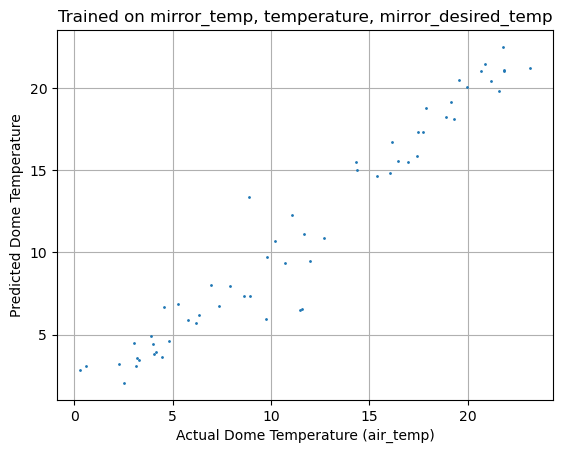

In [122]:
plt.plot(actual, predictions, '.', ms=2)
plt.grid()
plt.ylabel('Predicted Dome Temperature')
plt.xlabel('Actual Dome Temperature (air_temp)')
plt.title('Trained on mirror_temp, temperature, mirror_desired_temp')
print('median absolute deviation:', np.median(np.abs((predictions - actual))))